In [88]:
from collections import Counter

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [104]:
data_files_list = ["data/ids2018_processed/Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv",
                   "data/ids2018_processed/Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv", 
                   "data/ids2018_processed/Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv",
                   "data/ids2018_processed/Friday-23-02-2018_TrafficForML_CICFlowMeter.csv",
                   "data/ids2018_processed/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv"]

# removed "data/ids2018_processed/Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv",                   

save_dir = "data/ids2018_collaborative"

In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim, dropout_prob = 0.1):
        super(AutoEncoder, self).__init__()

        self.dropout = nn.Dropout(dropout_prob)
        
        self.encoder = nn.ModuleList([nn.Linear(in_features=input_dim, out_features=latent_dim*2)])
        self.encoder.append(nn.ReLU())
        self.encoder.append(nn.Linear(in_features=latent_dim*2, out_features=latent_dim))
        self.encoder.append(nn.ReLU())

        self.decoder = nn.ModuleList([nn.Linear(in_features=latent_dim, out_features=latent_dim*2)])
        self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Linear(in_features=latent_dim*2, out_features=input_dim))
        self.decoder.append(nn.ReLU())

    def forward(self, x):
        z = self.dropout(x)
        for layer in self.encoder:
            z = layer(z)

        # decoding
        for layer in self.decoder:
            z = layer(z)

        x_hat = z

        return x_hat

# Calculate the Loss & Load the thresholds

In [106]:
thresholds_list = list()
benign_loss_list = list()
attack_loss_list = list()

for csv_path in data_files_list:
    basename = csv_path.split("/")[-1].replace('.csv', '')
    print("\n\n"+basename+"\n"+"="*50)
    
    #load model
    with open("{}/model/{}_scaler.pkl".format(save_dir, basename), 'rb') as f:
        scaler = pickle.load(f)
    model = AutoEncoder(56, 6)
    model.load_state_dict(torch.load("{}/model/{}.model".format(save_dir, basename)))
    model.eval()

    #load thresholds
    with open("{}/model/{}_thresholds.pkl".format(save_dir, basename), 'rb') as f:
        thresholds = pickle.load(f)
    thresholds_list.append(thresholds)
    
    # load benign data
    Xy_benign_test = np.load("{}/{}_benign_test.npy".format(save_dir, basename), allow_pickle=True).astype(float)
    benign_identifier, X_benign_test = Xy_benign_test[:, 0], Xy_benign_test[:, 1:]

    # load malicious data
    Xy_attack_test = np.load("{}/{}_attack_test.npy".format(save_dir, basename), allow_pickle=True).astype(float)
    attack_identifier, X_attack_test = Xy_attack_test[:, 0], Xy_attack_test[:, 1:]
    
    # calculate the loss of benign data
    X_benign_test = scaler.transform(X_benign_test)
    X_benign_test = torch.FloatTensor(X_benign_test)

    X_hat = model(X_benign_test)
    benign_losses = ((X_benign_test-X_hat)**2).mean(dim=1).detach().numpy()
    df = pd.DataFrame(data={'id': benign_identifier, 'loss': benign_losses})
    benign_losses = df.groupby('id').mean()
    benign_loss_list.append(benign_losses)
    
    # calculate the loss of malicious data
    X_attack_test = scaler.transform(X_attack_test)
    X_attack_test = torch.FloatTensor(X_attack_test)

    X_hat = model(X_attack_test)
    attack_losses = ((X_attack_test-X_hat)**2).mean(dim=1).detach().numpy()
    df = pd.DataFrame(data={'id': attack_identifier, 'loss': attack_losses})
    attack_losses = df.groupby('id').mean()
    attack_loss_list.append(attack_losses)



Wednesday-14-02-2018_TrafficForML_CICFlowMeter


Thursday-15-02-2018_TrafficForML_CICFlowMeter


Thursday-22-02-2018_TrafficForML_CICFlowMeter


Friday-23-02-2018_TrafficForML_CICFlowMeter


Friday-02-03-2018_TrafficForML_CICFlowMeter


# Getting the RoC curve of each data



Wednesday-14-02-2018_TrafficForML_CICFlowMeter


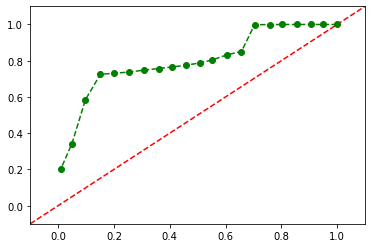



Thursday-15-02-2018_TrafficForML_CICFlowMeter


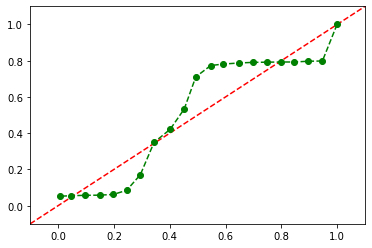



Thursday-22-02-2018_TrafficForML_CICFlowMeter


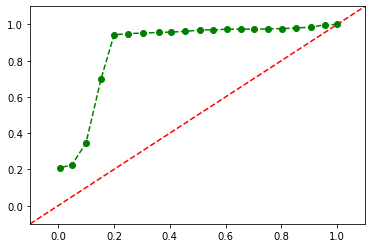



Friday-23-02-2018_TrafficForML_CICFlowMeter


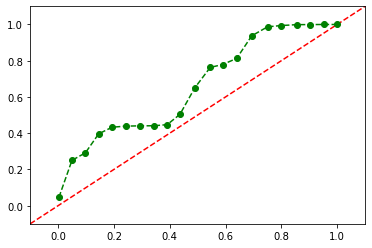



Friday-02-03-2018_TrafficForML_CICFlowMeter


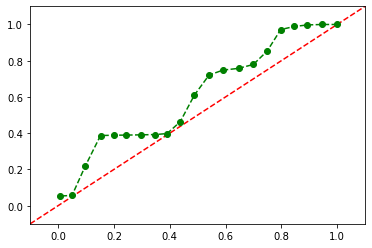

In [107]:
for i, csv_path in enumerate(data_files_list):
    basename = csv_path.split("/")[-1].replace('.csv', '')
    print("\n\n"+basename+"\n"+"="*50)
    
    thresholds = thresholds_list[i]
    benign_losses = benign_loss_list[i]
    attack_losses = attack_loss_list[i]
    
    # calculate the fpr and tpr
    fpr_record = list()
    tpr_record = list()
    total_negative = len(benign_losses)
    total_positive = len(attack_losses)
    
    for t in thresholds:
        fpr = np.sum((benign_losses>t).values)/total_negative
        fpr_record.append(fpr)
        tpr = np.sum((attack_losses>t).values)/total_positive
        tpr_record.append(tpr)

    # plot the graph
    fig = plt.figure()
    plt.plot([-0.1, 1.1], [-0.1, 1.1], 'r--')
    plt.plot(fpr_record, tpr_record, 'go--')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.show()

# Getting the RoC curve when collaborated

In [119]:
voting_thresholds = [2,3,4,5]
fpr_record_list = [[] for _ in range(len(data_files_list)*len(voting_thresholds))]
tpr_record_list = [[] for _ in range(len(data_files_list)*len(voting_thresholds))]

for i in range(len(thresholds_list[0])):
    malicious_voting_box = list()
    
    for o_id, _ in enumerate(data_files_list):
        t = thresholds_list[o_id][i]
        benign_losses = benign_loss_list[o_id]
        attack_losses = attack_loss_list[o_id]
        
        benign_votes = list(benign_losses.index[benign_losses['loss'] > t])
        attack_votes = list(attack_losses.index[attack_losses['loss'] > t])

        malicious_voting_box += benign_votes
        malicious_voting_box += attack_votes
        
    vote_count = Counter(malicious_voting_box)
    for v_id, k in enumerate(voting_thresholds):
        vote_result = {uid for uid, vc in vote_count.items() if vc>=k}
        for o_id, _ in enumerate(data_files_list):
            t = thresholds_list[o_id][i]
            benign_losses = benign_loss_list[o_id]
            attack_losses = attack_loss_list[o_id]
            
            benign_candidates = set(benign_losses.index.values)
            attack_candidates = set(attack_losses.index.values)
            
            benign_votes = set(benign_losses.index[benign_losses['loss'] > t])
            attack_votes = set(attack_losses.index[attack_losses['loss'] > t])
            
            fpr = len(benign_votes & vote_result)/len(benign_candidates) # can change to benign_candidates
            tpr = len(attack_votes & vote_result)/len(attack_candidates) # can change to attack_candidates

            fpr_record_list[o_id*len(voting_thresholds)+v_id].append(fpr)
            tpr_record_list[o_id*len(voting_thresholds)+v_id].append(tpr)



Wednesday-14-02-2018_TrafficForML_CICFlowMeter


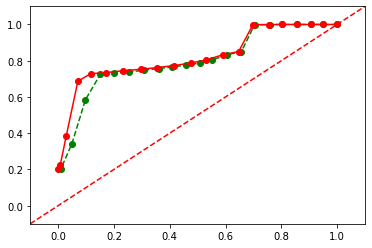

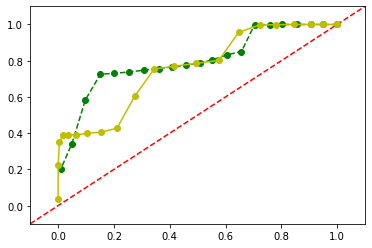

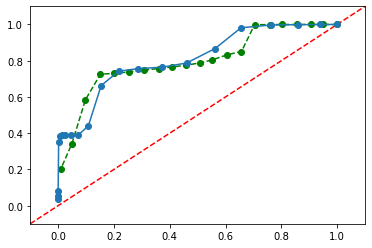

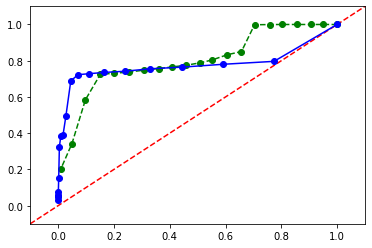



Thursday-15-02-2018_TrafficForML_CICFlowMeter


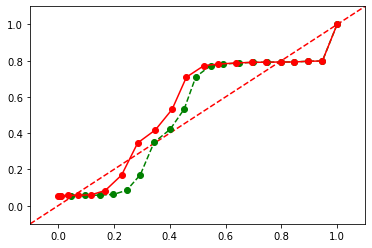

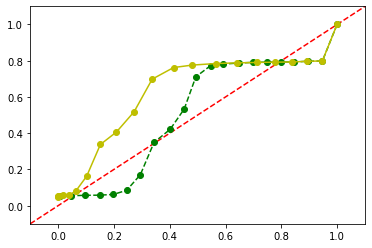

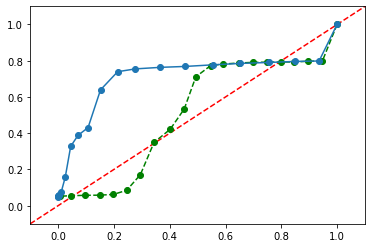

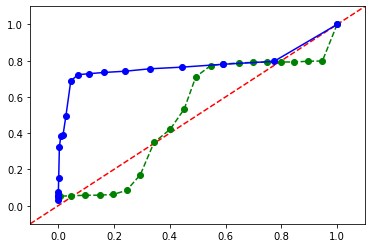



Thursday-22-02-2018_TrafficForML_CICFlowMeter


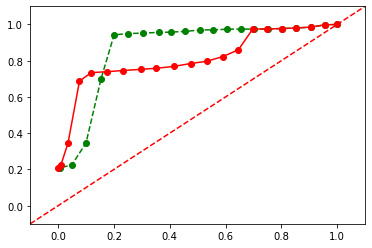

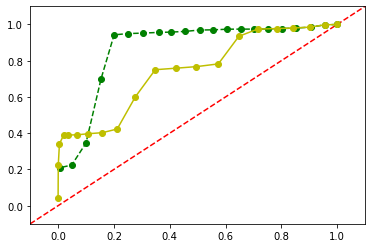

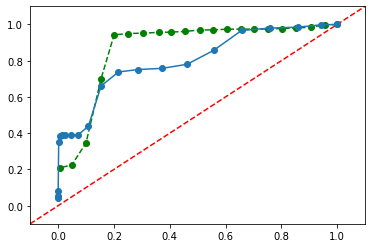

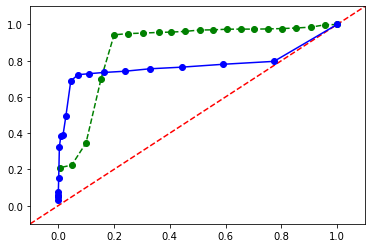



Friday-23-02-2018_TrafficForML_CICFlowMeter


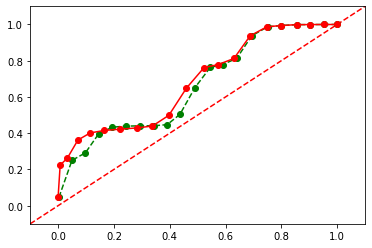

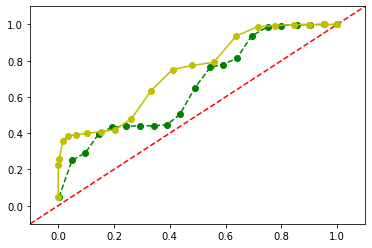

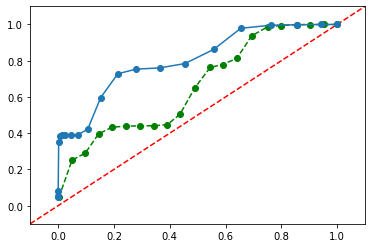

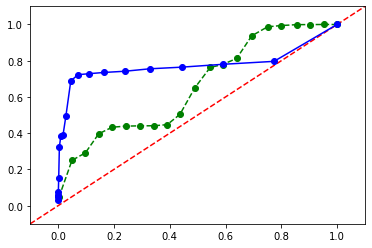



Friday-02-03-2018_TrafficForML_CICFlowMeter


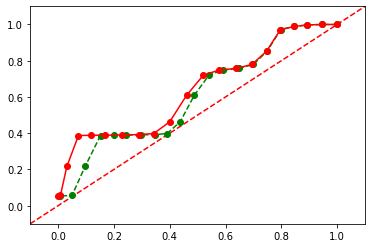

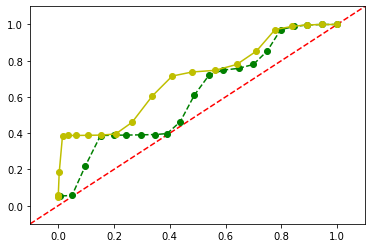

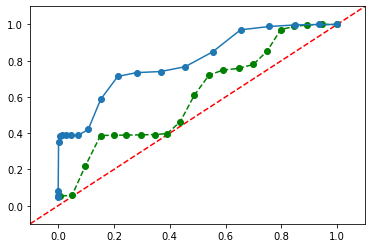

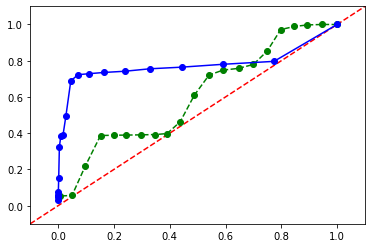

In [121]:
for o_id, csv_path in enumerate(data_files_list):
    basename = csv_path.split("/")[-1].replace('.csv', '')
    print("\n\n"+basename+"\n"+"="*50)

    thresholds = thresholds_list[o_id]
    benign_losses = benign_loss_list[o_id]
    attack_losses = attack_loss_list[o_id]
    
    # calculate the fpr and tpr
    fpr_record = list()
    tpr_record = list()
    total_negative = len(benign_losses)
    total_positive = len(attack_losses)
    
    for t in thresholds:
        fpr = np.sum((benign_losses>t).values)/total_negative
        fpr_record.append(fpr)
        tpr = np.sum((attack_losses>t).values)/total_positive
        tpr_record.append(tpr)
    # plot the graph

    for i, style in enumerate(['ro-', 'yo-', 'o-', 'bo-']):
        fig = plt.figure()
        plt.plot([-0.1, 1.1], [-0.1, 1.1], 'r--')
        plt.plot(fpr_record, tpr_record, 'go--')
        plt.plot(fpr_record_list[o_id*len(voting_thresholds)+i], tpr_record_list[o_id*len(voting_thresholds)+i], style)
        plt.xlim(-0.1, 1.1)
        plt.ylim(-0.1, 1.1)
        plt.show()